Credit: https://dcato98.github.io/blog/jupyter/visualization/python/cuda/numpy/pytorch/video/2020/04/28/CUDA-Accelerated-Julia-Fractals.html

# Julia Fractals

In the first section, you'll learn how to generate impressively cool images like this one, commonly named the Mandelbrot set, both in NumPy and in PyTorch.

In the second section, you'll speed up your image generation by over a factor of 10, learning about broadcasting and the speedups that come from maxing out the GPU.

In the third section, you'll generate mesmerizing videos exploring the very fabric of Julia fractal-space. 

![mandelbrot](mandelbrot.png)

Above: The Mandelbrot set, which you'll be able to generate yourself by the end of Part 1.

### Hang on...what is a Julia fractal?

Steven Wittens does an incredible job of showing what a Julia set is in his post [How to Fold a Julia Fractal](http://acko.net/blog/how-to-fold-a-julia-fractal/). If you need a refresher on Julia sets, or just want to marvel at Witten's impressive ability to build intuition through evocative visualizations, I suggest you take a few minutes to check it out now. Then return when you're ready to start coding.

## Part 1: From Math to Code

A Julia fractal is computed by iteratively applying a function over a set of points in the complex plane. Mathematically, this looks like:

$$ z_{n+1} = f_n(z_n, c) $$

Where $ f $ is a complex, non-linear function (i.e. map) and $ z_0 $ and $ c $ are both complex numbers.

By applying these maps iteratively over the points in the complex plane, the points that diverge to infinity are excluded from the Julia set. Those that don't diverge are part of the set.

### Defining the complex plane

Let's get started defining the region of the complex plane we want to plot (`xrange` and `yrange`), as well as the `resolution` of our image.

In [9]:
xrange = yrange = (-2, 2)
resolution = (5, 5) # (x-resolution, y-resolution)

Each point corresponds to one pixel, so in this case, we'll end up with a 5x5 pixel image with 25 points evenly spaced in the grid defined by the real x-axis ranging from -2 to 2, and the imaginary y-axis ranging from -2i to 2i.

This fully specifies our complex plane. Let's create this with PyTorch:

In [11]:
import torch

def complex_plane(xrange=(-2,2), yrange=None, res=1000, device='cuda'):
    '''Return a 2-tuple of grids corresponding to the real and imaginary points 
    on the complex plane, respectively.'''
    if yrange == None: yrange = xrange
    if type(res) == int: res = (res,res)
    
    # np.linspace(...) --> torch.linspace(...).cuda()
    x = torch.linspace(xrange[0], xrange[1], res[0]).to(device)
    y = torch.linspace(yrange[1], yrange[0], res[1]).to(device)
    
    # np.meshgrid --> torch.meshgrid
    real_plane, imag_plane = torch.meshgrid(x,y)
    
    cplane = tuple([real_plane.transpose(0,1), imag_plane.transpose(0,1)])
    
    return cplane

In [12]:
complex_plane(xrange, yrange, resolution)

(tensor([[-2., -1.,  0.,  1.,  2.],
         [-2., -1.,  0.,  1.,  2.],
         [-2., -1.,  0.,  1.,  2.],
         [-2., -1.,  0.,  1.,  2.],
         [-2., -1.,  0.,  1.,  2.]], device='cuda:0'),
 tensor([[ 2.,  2.,  2.,  2.,  2.],
         [ 1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1.],
         [-2., -2., -2., -2., -2.]], device='cuda:0'))

### Defining divergence

Now that we have our complex plane, we need to know how to detect whether a point has diverged. This will determine what color we plot it.

Of course, we don't have an infinitely sized numeric data type to determine whether a point has 'reached infinity' yet. On top of this, we don't have an infinite amount of time to find out whether each point exceeds this bound.

One way to approximate this is to count how many iterations it takes before a point exceeds a specified `divergence_value`, up to a fixed number of iterations, `n_iterations`.

In [13]:
divergence_value = 2
n_iterations = 50

`n_iterations` is an especially convenient parameter because it directly manages our tradeoff between time and accuracy. More iterations take longer to compute, but result in higher quality maps.

### Choosing a mapping function

Now that we know how to count convergence, we just need to choose a map. Let's recall our generating function:

$$ z_{n+1} = f_n(z_n, c) $$

We'll spend most of our time here working with the most popular function for generating Julia fractals, the quadratic map:

$$ f(z) = z^2 + c $$

Two other popular choices are the sine map (implemented at the very end) and cosine map (left as an exercise for the reader):

$$ f(z) = c * sin(z) $$
$$ f(z) = c * cos(z) $$

Let's start by implementing the quadratic map in PyTorch:

In [14]:
def complex_magnitude(r,i):
    '''returns the magnitude of a complex tensor, given a real component, `r`, and an imaginary component, `i`'''
    return torch.sqrt(r**2+i**2)

def quadratic_method(c, z, n_iterations, divergence_value, device='cuda'):
    '''Iteratively apply the quadratic map `z = z^2 + c` for `n_iterations` times
        c: tuple of the real and imaginary components of the constant value
        z: tuple of the real and imaginary components of the initial z-value
    '''
    # np.zeros_like(...) --> torch.zeros_like(...).cuda()
    stable_steps = torch.zeros_like(z[0]).to(device)
    
    for i in range(n_iterations):
        # numpy handled squaring complex magnitudes, for PyTorch we implement this ourselves
        mask = torch.lt(complex_magnitude(*z), divergence_value).to(device)
        stable_steps += mask.to(torch.float32)
        
        # likewise, we manually implement one iteration of the quadratic map
        z = (z[0]**2-z[1]**2 + c[0], # real
             2*z[0]*z[1] + c[1])     # imaginary
        
    # don't forget to put the array onto the cpu for plotting!
    return stable_steps / n_iterations

Finally, to visually verify our model, let's choose a value for `c` for which the image is already known. Paul Bourke lists of some particularly interesting on his [website](http://paulbourke.net/fractals/juliaset/). I like $ c = 0.54 + 0.54i $, which, according to Bourke's website, looks like this:

![dragon-fractal](http://paulbourke.net/fractals/juliaset/sample4s.png)

In [16]:
c = [-0.54, 0.54]

z_init = complex_plane(xrange, yrange, resolution)

img = quadratic_method(c, z_init, n_iterations, divergence_value)
img

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0400, 0.0600, 0.0200, 0.0000],
        [0.0000, 0.0800, 1.0000, 0.0800, 0.0000],
        [0.0000, 0.0200, 0.0600, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0')

### Plotting a Julia set

This is difficult to inspect by eye. Let's write a function to plot these values. By experimentation, I've found that plotting the negative log of the returned values usually gives a nice contrast of values. `eps` controls the sensitivity to values very close to zero.

In [18]:
import matplotlib.pyplot as plt

def plot_julia(julia_img, sz=16, eps=.1):
    img = -torch.log(julia_img + eps)
    img = img.cpu()
    plt.figure(figsize=(sz,sz))
    plt.imshow(img)
    plt.show()

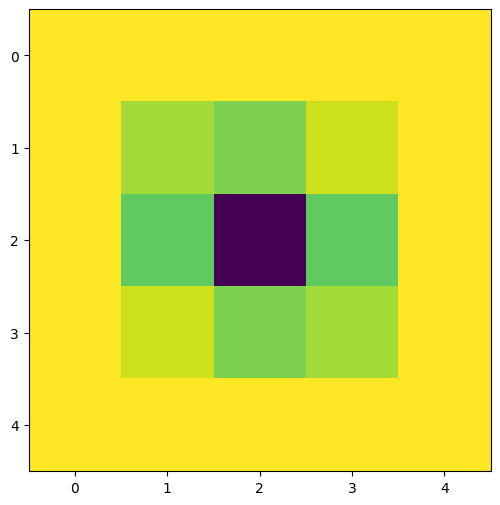

In [19]:
plot_julia(img, sz=6)

Hmm...looks like we don't have enough resolution to get a clear picture.

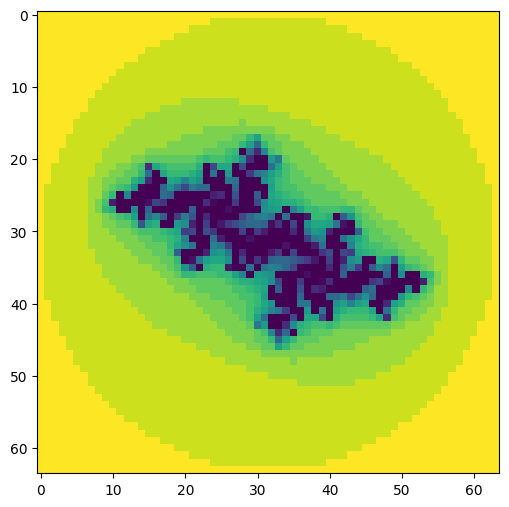

In [21]:
resolution = 64

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution)
img = quadratic_method(c, z_init, n_iterations, divergence_value)
plot_julia(img, sz=6)

This is looking promising! Let's increase the resolution even further, and make the image bigger for a better comparison.

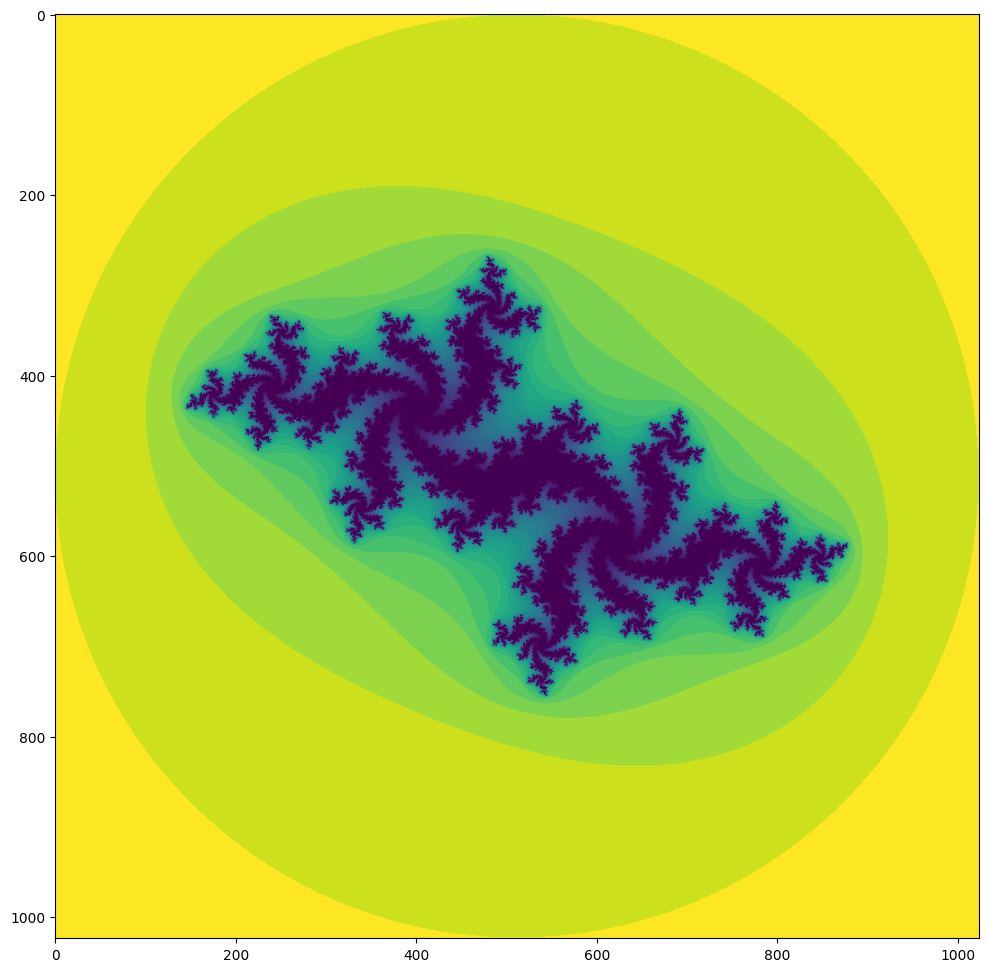

In [22]:
resolution = 1024

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution)
img = quadratic_method(c, z_init, n_iterations, divergence_value)
plot_julia(img, sz=12)

We're starting to get very close to the original, but we're lacking in detail. Let's increase how many iterations we do from 50 to 200 iterations.

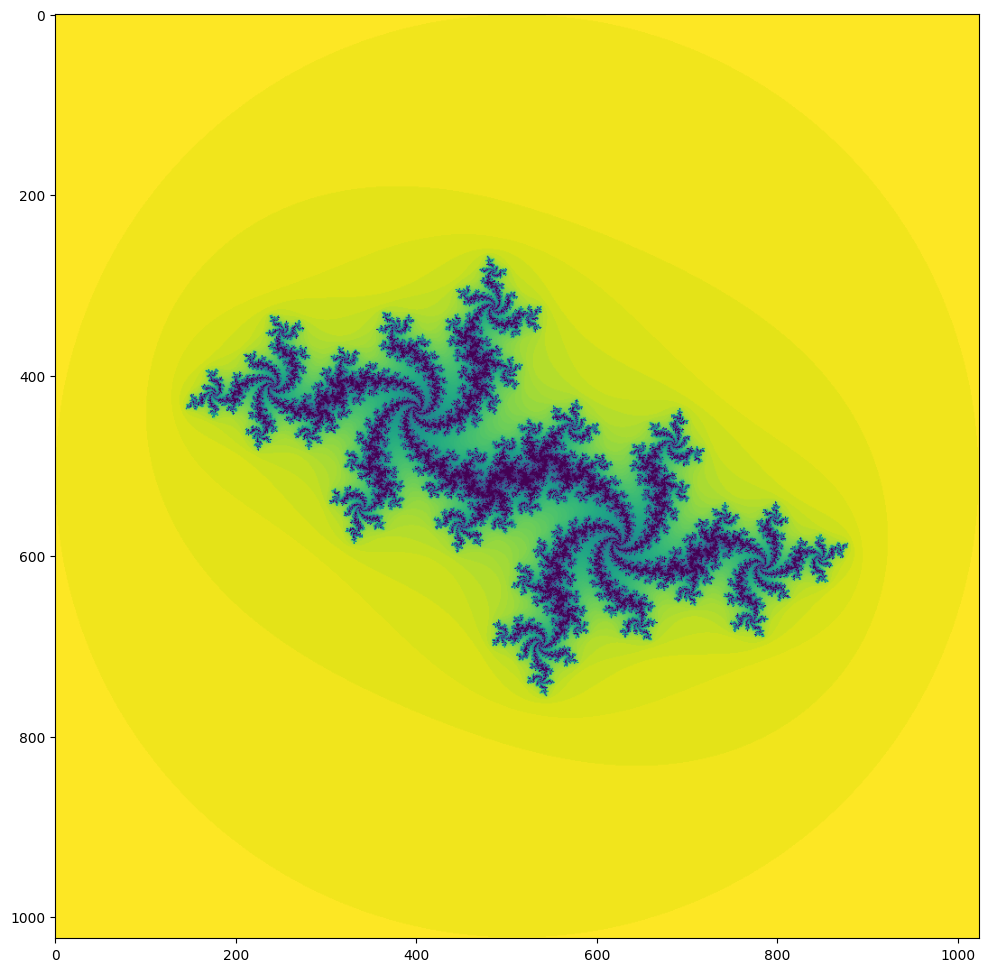

In [23]:
n_iterations = 200

c = [-0.54, 0.54]
z_init = complex_plane(xrange, yrange, resolution)
img = quadratic_method(c, z_init, n_iterations, divergence_value)
plot_julia(img, sz=12)

Looks like the same fractal to me!

And along the way, we've seen how to improve the quality of our generated images by increasing the image resolution and/or increasing the number of iterations.

So we used a constant value for `c` to create this image, but the famous Mandelbrot set is generated by varying `c`, setting it equal the complex plane. That is, `c` varies for each point in the plane, so that `c` is equal to the coordinate at that point.

We can actually already do this, using the same function we use to initialize the complex plane! Let's test it out:

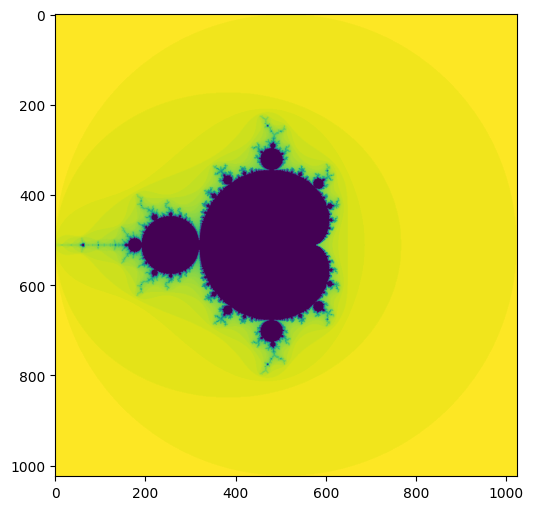

In [24]:
# Mandelbrot set
c = complex_plane(xrange, yrange, resolution)

z_init = complex_plane(xrange, yrange, resolution)
img = quadratic_method(c, z_init, n_iterations, divergence_value)
plot_julia(img, sz=6)